Tentando Aplicar o Shap

In [226]:
# !pip install yfinance 
# ! pip install tensorflow
# !pip install statsmodels

In [227]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, GRU# captum (biblioteca de interpretação pytorch)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Download data for the stock (I'm using the Bovespa index as an example)
# data = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data = pd.read_csv("data.csv")
data = data[['Close']]


In [228]:
data.shape

(4154, 1)

In [229]:
data.head()#.values.reshape(-1,1) #45383. 116534.

,Close
0,45383.0
1,44445.0
2,44020.0
3,42245.0
4,42830.0


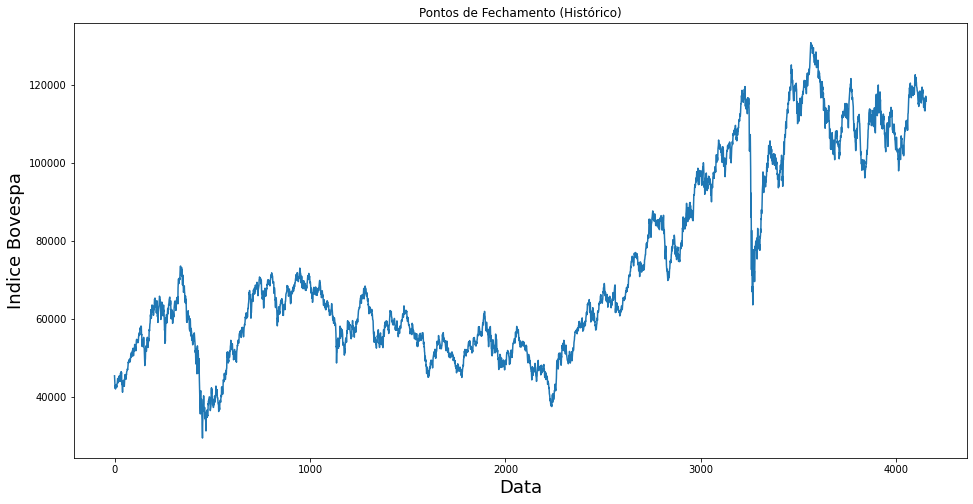

In [230]:
plt.figure(figsize=(16,8))
plt.title("Pontos de Fechamento (Histórico)")
plt.plot(data["Close"])
plt.xlabel("Data",fontsize=18)
plt.ylabel("Indice Bovespa",fontsize=18)
plt.show()

In [231]:
# Normalize the data

def create_lagged_dataframe(data, lags, include_lag0=False):
    lagged_data = data.copy()

    if include_lag0:
        lagged_data['lag0'] = lagged_data['Close']

    for lag in range(1, lags + 1):
        lagged_data[f'lag{lag}'] = lagged_data['Close'].shift(lag)

    return lagged_data
# Split the data into train and test sets


# Create lag features for the entire dataset
look_back = 12
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_data = create_lagged_dataframe(data, look_back, include_lag0)
lagged_data = lagged_data.dropna()  # Drop rows with NaN values

scaler = MinMaxScaler()
train_size = int(len(lagged_data) * 0.8)
test_size = len(lagged_data) - train_size
train, test = lagged_data[:train_size], lagged_data[train_size:len(data)]
train.head()


,Close,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
12,42478.0,42735.0,42624.0,42919.0,43095.0,42670.0,42336.0,42007.0,42830.0,42245.0,44020.0,44445.0,45383.0
13,43428.0,42478.0,42735.0,42624.0,42919.0,43095.0,42670.0,42336.0,42007.0,42830.0,42245.0,44020.0,44445.0
14,43553.0,43428.0,42478.0,42735.0,42624.0,42919.0,43095.0,42670.0,42336.0,42007.0,42830.0,42245.0,44020.0
15,44177.0,43553.0,43428.0,42478.0,42735.0,42624.0,42919.0,43095.0,42670.0,42336.0,42007.0,42830.0,42245.0
16,44687.0,44177.0,43553.0,43428.0,42478.0,42735.0,42624.0,42919.0,43095.0,42670.0,42336.0,42007.0,42830.0


In [232]:
lagged_data.shape

(4142, 13)

In [233]:
trainX= train.drop(columns='Close').to_numpy()
testX = test.drop(columns='Close').to_numpy()
trainY= train['Close'].to_numpy()
testY= test['Close'].to_numpy()

print("TrainX shape:", trainX.shape)
print("TrainY shape:", trainY.shape)
print("TestX shape:", testX.shape)
print("TestY shape:", testY.shape)

TrainX shape: (3313, 12)
TrainY shape: (3313,)
TestX shape: (829, 12)
TestY shape: (829,)


In [234]:
data["Close"][:train_size]

0       45383.0
1       44445.0
2       44020.0
3       42245.0
4       42830.0
         ...   
3308    85663.0
3309    85469.0
3310    87946.0
3311    86949.0
3312    87403.0
Name: Close, Length: 3313, dtype: float64

In [235]:
trainX[:,0:1]

array([[42735.],
       [42478.],
       [43428.],
       ...,
       [92795.],
       [92376.],
       [93531.]])

In [236]:
scaler.fit(trainX[:,0:1])
trainX[:,0:1].shape

(3313, 1)

In [237]:
scaler.min_[0], scaler.data_max_[0], #scaler.

(-0.3267179470103116, 119528.0)

In [238]:

trainX = np.apply_along_axis(lambda x: (x-scaler.min_[0])/(scaler.data_max_[0] - scaler.min_[0]),0, trainX)
testX = np.apply_along_axis(lambda x: (x-scaler.min_[0])/(scaler.data_max_[0] - scaler.min_[0]),0, testX)

trainY = np.apply_along_axis(lambda x: (x-scaler.min_[0])/(scaler.data_max_[0] - scaler.min_[0]),0, trainY)
testY = np.apply_along_axis(lambda x: (x-scaler.min_[0])/(scaler.data_max_[0] - scaler.min_[0]),0, testY)

# train = scaler.transform(train)#use fit only in training that is wrong
# testX = scaler.transform(testX.T).T#use fit only in training that is wrong

In [239]:
trainX

array([[0.35753305, 0.3566044 , 0.35907243, ..., 0.36828364, 0.37183928,
        0.37968679],
       [0.35538293, 0.35753305, 0.3566044 , ..., 0.3534336 , 0.36828364,
        0.37183928],
       [0.36333083, 0.35538293, 0.35753305, ..., 0.35832784, 0.3534336 ,
        0.36828364],
       ...,
       [0.7763459 , 0.79216642, 0.8094092 , ..., 0.73123526, 0.72743699,
        0.73577811],
       [0.77284046, 0.7763459 , 0.79216642, ..., 0.74141694, 0.73123526,
        0.72743699],
       [0.78250344, 0.77284046, 0.7763459 , ..., 0.76171339, 0.74141694,
        0.73123526]])

In [240]:
# trainX = np.array(trainX)
# testX = np.array(testX)

In [241]:
import tensorflow as tf

tf.random.set_seed(22)

# Reshape the input data for LSTM and GRU models
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [242]:


# Define the GRU model
def GRU_Model(output_window):
    model = Sequential()
    model.add(GRU(128, return_sequences=False, input_shape=(1, look_back)))
    model.add(Dense(output_window))
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer , loss='mean_squared_error')
    return model

# Define the LSTM model
def LSTM_Model(output_window):
    # n_steps = x_train.shape[-2]
    # n_features = x_train.shape[-1]
    model = Sequential()
    # model.add(tf.keras.layers.Embedding(1, 6, mask_zero=True))


    model.add(Bidirectional(LSTM(64, activation='relu', input_shape=(output_window, 1), return_sequences=True)))
    model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
    model.add(Bidirectional(LSTM(16, activation='relu')))
    # model.add(LSTM(128, return_sequences=False, input_shape=(1, look_back)))
    model.add(Dense(output_window))
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer , loss='mean_squared_error')
    return model

# Define the baseline model
def baseline_model(output_window):
    last_known_value = trainY[-1]
    return np.full((len(testY), output_window), last_known_value)

# Train and evaluate the models
output_window = 1
gru_model = GRU_Model(output_window)
lstm_model = LSTM_Model(output_window)
# lstm_model.summary()

In [243]:
# class LoaderX(tf.data.Dataset):
#   def __init__(self, data_x, lags, transform) -> None:
#     self.data_x = data_x
#     self.lags = lags
#     self.transform = transform
     
#   def __getitem__(self, idx):
#     def along_axis(i):
#       print(i)
#       return self.data_x.to_numpy().T[:,i:i - self.lags]
#     idxs = self.data_x.iloc[idx].index.to_numpy()
#     # lagged_data = np.apply_along_axis(lambda x: self.data_x.to_numpy()[x+1:x - self.lags:-1], idxs)
#     lagg_data = np.apply_along_axis(along_axis, 0, idxs)
#     # lagged_data = np.apply_over_axes(along_axis, idxs, 0)

#     cols  = ['Close']
#     cols.extends([f'lag{lag}' for lag in idxs])
#     return pd.DataFrame(lagg_data, columns=cols, index=idxs)
#     if include_lag0:
#         lagged_data['lag0'] = lagged_data['Close']
#     for lag in range(1, self.lags + 1):
#         lagged_data[f'lag{lag}'] = lagged_data['Close'].shift(lag)
#     return lagged_data.iloc[idx]
#   def __len__(self):
#      return len(self.data_x) - self.lags
#   # def __maxlen__(self):
#   #    return len(self.data_x) - self.lags

In [244]:
# le = LoaderX(data_x=data, lags = 6, transform=MinMaxScaler()) ##.first_valid_index()
# # print(len(le), type(lagged_data['Close'].shift(10)[12]), lagged_data['Close'].shift(10)[12], )
# le[15]
# # np.float64.NaN

In [245]:
# x_tester = np.ones((5,1,6))
# lstm_model.predict(x_tester).shape

In [246]:

print("gru_model")
print("*"*50)
gru_model.fit(trainX, trainY, epochs=300, batch_size=64)
print("lstm_model")
print("*"*50)
lstm_model.fit(trainX, trainY, epochs=300, batch_size=64)

gru_predictions = gru_model.predict(testX)
lstm_predictions = lstm_model.predict(testX)
baseline_predictions = baseline_model(output_window)

# Inverse transform the predictions
gru_predictions = scaler.inverse_transform(gru_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
baseline_predictions = scaler.inverse_transform(baseline_predictions)



gru_model
**************************************************


Epoch 1/300
52/52 [==============================] - 4s 5ms/step - loss: 0.2110
Epoch 2/300
52/52 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 3/300
52/52 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 4/300
52/52 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 5/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 6/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 7/300
52/52 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 8/300
52/52 [==============================] - 0s 6ms/step - loss: 9.7845e-04
Epoch 9/300
52/52 [==============================] - 0s 7ms/step - loss: 9.3499e-04
Epoch 10/300
52/52 [==============================] - 0s 5ms/step - loss: 8.9135e-04
Epoch 11/300
52/52 [==============================] - 0s 5ms/step - loss: 8.4818e-04
Epoch 12/300
52/52 [==============================] - 0s 6ms/step - loss: 8.0557e-04
Epoch 13/300
52/5

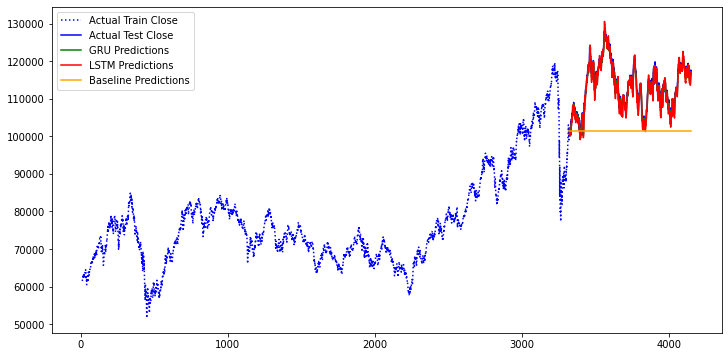

In [247]:
 #Inverse transform both train and test data
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Create a time index for plotting
time_index_train = range(len(data) - len(testY) - len(trainY), len(data) - len(testY))
time_index_test = range(len(data) - len(testY), len(data))

# Plot all true values and the predictions with different colors
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, trainY, label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(time_index_test, testY, label='Actual Test Close', color='blue')
plt.plot(time_index_test, gru_predictions, label='GRU Predictions', color='green')
plt.plot(time_index_test, lstm_predictions, label='LSTM Predictions', color='red')
plt.plot(time_index_test, baseline_predictions, label='Baseline Predictions', color='orange')
plt.legend()
plt.show()

In [248]:
# Calculate the mean squared error for each model
gru_mse = mean_squared_error(testY, gru_predictions)
lstm_mse = mean_squared_error(testY, lstm_predictions)
baseline_mse = mean_squared_error(testY, baseline_predictions)

# Compare the models using Mean Squared Error
print("GRU Model RMSE: ", np.sqrt(gru_mse))
print("LSTM Model RMSE: ", np.sqrt(lstm_mse))
print("Baseline Model RMSE: ", np.sqrt(baseline_mse))


GRU Model RMSE:  1197.1348430720789
LSTM Model RMSE:  1492.4996756113528
Baseline Model RMSE:  13277.737875690242


In [249]:
# Calculate the Mean Absolute Percentage Error (MAPE) for each model
def calculate_mape(true_values, predicted_values):
    abs_percentage_errors = np.abs((true_values - predicted_values) / true_values)
    mape = np.mean(abs_percentage_errors) * 100  # Convert to percentage
    return mape

gru_mape = calculate_mape(testY, gru_predictions)
lstm_mape = calculate_mape(testY, lstm_predictions)
baseline_mape = calculate_mape(testY, baseline_predictions)

# Compare the models using Mean Absolute Percentage Error
print("GRU Model MAPE: {:.2f}%".format(gru_mape))
print("LSTM Model MAPE: {:.2f}%".format(lstm_mape))
print("Baseline Model MAPE: {:.2f}%".format(baseline_mape))


GRU Model MAPE: 0.84%
LSTM Model MAPE: 1.04%
Baseline Model MAPE: 10.18%


In [250]:
def calculate_mae(true_values, predicted_values):
    abs_errors = np.abs(true_values - predicted_values)
    mae = np.mean(abs_errors)
    return mae

gru_mae = calculate_mae(testY, gru_predictions)
lstm_mae = calculate_mae(testY, lstm_predictions)
baseline_mae = calculate_mae(testY, baseline_predictions)

# Compare the models using Mean Absolute Percentage Error
print("GRU Model MAE: {:.2f}".format(gru_mae))
print("LSTM Model MAE: {:.2f}".format(lstm_mae))
print("Baseline Model MAE: {:.2f}".format(baseline_mae))

GRU Model MAE: 951.32
LSTM Model MAE: 1174.31
Baseline Model MAE: 11819.37


In [251]:
# Calculate the MASE for each model
def calculate_mase(model_mae, baseline_mae):
    mase = model_mae / baseline_mae
    return mase

gru_mase = calculate_mase(gru_mae, baseline_mae)
lstm_mase = calculate_mase(lstm_mae, baseline_mae)

# Compare the models using Mean Absolute Scaled Error
print("GRU Model MASE: {:.2f}".format(gru_mase))
print("LSTM Model MASE: {:.2f}".format(lstm_mase))

GRU Model MASE: 0.08
LSTM Model MASE: 0.10


In [252]:
# Assuming gru_predictions is your NumPy array
baseline_predictions = baseline_predictions.reshape(-1, 1)  # Reshape the array to have one column

# Create a DataFrame
df = pd.DataFrame(data=baseline_predictions, columns=['BASELINE_Predictions'])

# Save the DataFrame to a CSV file
df.to_csv('baseline_predictions.csv', index=False)

In [253]:
# Assuming gru_predictions is your NumPy array
gru_predictions = gru_predictions.reshape(-1, 1)  # Reshape the array to have one column

# Create a DataFrame
df = pd.DataFrame(data=gru_predictions, columns=['GRU_Predictions'])

# Save the DataFrame to a CSV file
df.to_csv('gru_predictions.csv', index=False)

In [254]:
# Assuming gru_predictions is your NumPy array
lstm_predictions = lstm_predictions.reshape(-1, 1)  # Reshape the array to have one column

# Create a DataFrame
df = pd.DataFrame(data=lstm_predictions, columns=['LSTM_Predictions'])

# Save the DataFrame to a CSV file
df.to_csv('lstm_predictions.csv', index=False)

In [255]:
# Assuming gru_predictions is your NumPy array
trainY_predictions = trainY

# Create a DataFrame
df = pd.DataFrame(data=trainY_predictions, columns=['trainY_predictions'])

# Save the DataFrame to a CSV file
df.to_csv('trainY_predictions.csv', index=False)

In [256]:
# Assuming gru_predictions is your NumPy array
testY_predictions = testY

# Create a DataFrame
df = pd.DataFrame(data=testY_predictions, columns=['testY_predictions'])

# Save the DataFrame to a CSV file
df.to_csv('testY_predictions.csv', index=False)

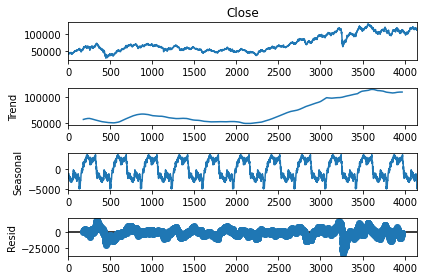

In [257]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['Close'], model='additive',period=365)
result.plot()
plt.show()

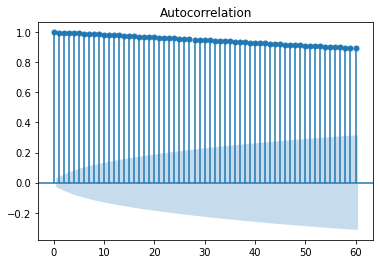

In [258]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['Close'], lags=60)
plt.show()

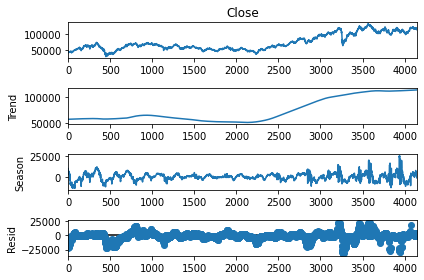

In [259]:
from statsmodels.tsa.seasonal import STL
stl = STL(data['Close'], period=365,robust=True)#looking for pattern that repeats annualy
res = stl.fit()
fig = res.plot()

In [260]:
# Download data for the stock (I'm using the Bovespa index as an example)
# data2 = yf.download('^BVSP', '2007-01-01', '2023-09-22')
data2 = pd.read_csv("data.csv")
data2= data2[['Close']]
data2

last_60_days = data2[-look_back:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = X_test.reshape(-1,1,X_test.shape[1])
pred_price = lstm_model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[[115168.89]]


In [261]:
# Download data for the stock (I'm using the Bovespa index as an example)
# data2 = yf.download('^BVSP', '2023-09-23', '2023-09-26')
data2 = pd.read_csv("data.csv")
data2= data2[['Close']]
data2

,Close
0,45383.0
1,44445.0
2,44020.0
3,42245.0
4,42830.0
...,...
4149,115156.0
4150,116737.0
4151,117051.0
4152,115754.0


In [262]:
# Download data for the stock (I'm using the Bovespa index as an example)
# data3 = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data3 = pd.read_csv("data.csv")

data3 = data3[['Close']]

# Create lag features for the entire dataset
look_back = 6
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_data2 = create_lagged_dataframe(data3, look_back, include_lag0)
#lagged_data2 = lagged_data.dropna()  # Drop rows with NaN values
lagged_data2

,Close,lag1,lag2,lag3,lag4,lag5,lag6
0,45383.0,NaN,NaN,NaN,NaN,NaN,NaN
1,44445.0,45383.0,NaN,NaN,NaN,NaN,NaN
2,44020.0,44445.0,45383.0,NaN,NaN,NaN,NaN
3,42245.0,44020.0,44445.0,45383.0,NaN,NaN,NaN
4,42830.0,42245.0,44020.0,44445.0,45383.0,NaN,NaN
...,...,...,...,...,...,...,...
4149,115156.0,114170.0,113284.0,113607.0,113419.0,115057.0,116565.0
4150,116737.0,115156.0,114170.0,113284.0,113607.0,113419.0,115057.0
4151,117051.0,116737.0,115156.0,114170.0,113284.0,113607.0,113419.0
4152,115754.0,117051.0,116737.0,115156.0,114170.0,113284.0,113607.0


In [263]:
# Save the final dataframe to a CSV file
lagged_data2.to_csv('final_data.csv', index=False)  # Setting index=False to exclude the index column

# Print the first few rows of the final dataframe
print(lagged_data2.head(7))

     Close     lag1     lag2     lag3     lag4     lag5     lag6
0  45383.0      NaN      NaN      NaN      NaN      NaN      NaN
1  44445.0  45383.0      NaN      NaN      NaN      NaN      NaN
2  44020.0  44445.0  45383.0      NaN      NaN      NaN      NaN
3  42245.0  44020.0  44445.0  45383.0      NaN      NaN      NaN
4  42830.0  42245.0  44020.0  44445.0  45383.0      NaN      NaN
5  42007.0  42830.0  42245.0  44020.0  44445.0  45383.0      NaN
6  42336.0  42007.0  42830.0  42245.0  44020.0  44445.0  45383.0


   Feature  Importance
0     lag1    0.997555
1     lag2    0.000457
53   lag54    0.000089
43   lag44    0.000076
2     lag3    0.000075
14   lag15    0.000067
58   lag59    0.000066
59   lag60    0.000061
4     lag5    0.000060
8     lag9    0.000057


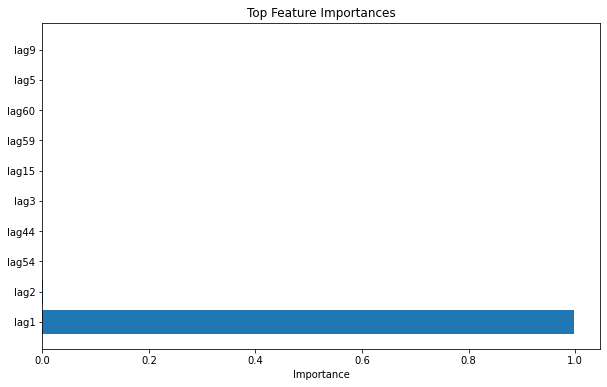

In [264]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Download data for the stock (I'm using the Bovespa index as an example)
# data3 = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data3 = pd.read_csv("data.csv")

data3 = data3[['Close']]

# Create lag features for the entire dataset
look_back = 60
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_data = create_lagged_dataframe(data3, look_back, include_lag0)
lagged_data = lagged_data.dropna()  # Drop rows with NaN values
lagged_data

# Split the data into features (X) and the target variable (Y)
X = lagged_data.drop(columns='Close')
Y = lagged_data['Close']

# Create and fit the Decision Tree model
regression_tree = DecisionTreeRegressor()
regression_tree.fit(X, Y)

# Calculate feature importances
feature_importances = regression_tree.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features (adjust N as needed)
top_n = 10
print(importance_df.head(top_n))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:top_n], importance_df['Importance'][:top_n])
plt.xlabel('Importance')
plt.title('Top Feature Importances')
plt.show()
#lag1 is way more important than others